# Objetivo
A partir de um sinal de vibração genérico: 

    1. Visualizar o sinal no tempo, seus parâmetros estatísticos e histograma. 
    2. Visualizar o sinal na frequênica, identificando os picos dominantes.
    3. Testar os métodos de extração de características.

Abaixo a importação das bibliotecas.

In [1]:
# bibliotecas mais importantes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import scipy.signal as signal

# tema padrão do seaborn
sns.set_theme()

Utilizando o módulo de inicialização, lemos o sinal de um arquivo genérico escolhido.

In [2]:
from initialize import Measurement
address = '../mafaulda/imbalance/35g/56.7296.csv'
ratio = 50

m1 = Measurement(address, ratio, verbose=True)


Sinal com shape (5000, 8)
a frequência de aquisição foi reduzida de 50kHz para 1.0kHz



# Análise no tempo
Temos a visualização deles no tempo.

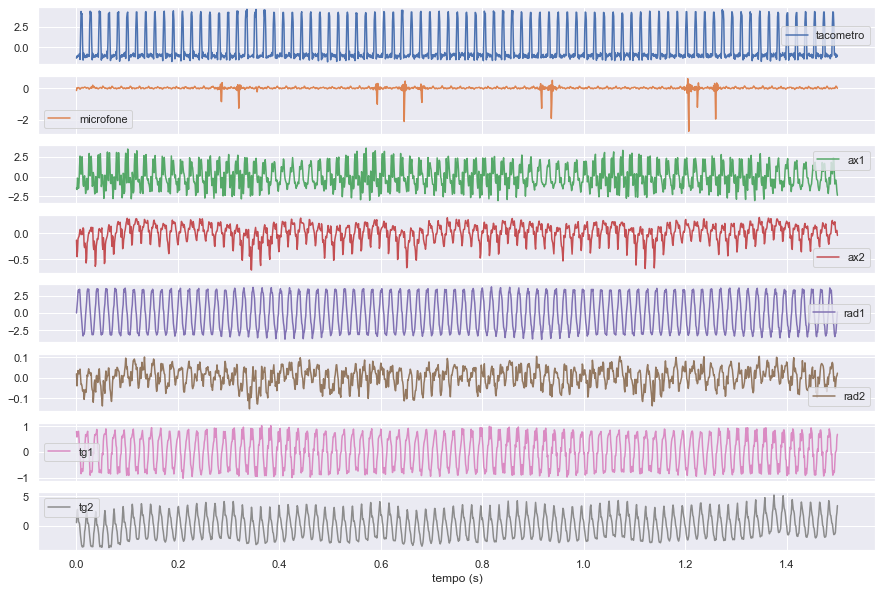

In [3]:
m1.time['tempo (s)'] = np.linspace(0, 5, m1.time.shape[0])
m1.time.loc[:1500].plot(subplots=True, x='tempo (s)', layout=(8,1), figsize=(15,10))
m1.time.pop('tempo (s)');

Note que as amplitudes sao diferentes. Temos uma ideia melhor a partir do boxplot

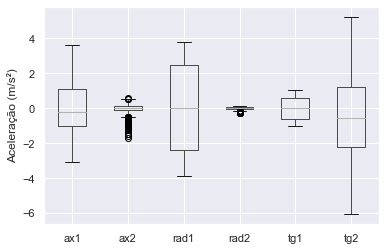

In [4]:
# checa nível dos sinais de aceleração
m1.time_acc.boxplot()
plt.ylabel('Aceleração (m/s²)')
plt.show()

Como curiosidade, pode-se também escutar o som gerado pelo microfone.

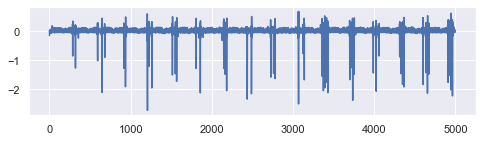

Som do microfone


In [5]:
# detalha sinal do microfone no tempo
m1.time['microfone'].plot(figsize=(8,2))
plt.show()

from IPython.display import Audio, display
print('Som do microfone')
display(Audio(m1.time['microfone'], rate=m1.sampling_freq))

# Extração de parâmetros

Uma referencia para técnicas de extração de características: http://mkalikatzarakis.eu/wp-content/uploads/2018/12/IMS_dset.html

## Domínio do tempo

São sugeridos alguns parâmetros. Em destaque, aqueles que já foram implementados:

 - Momentos estatísticos: 
  - **média**, 
  - desvio padrão, 
  - assimetria, 
  - **curtose**
 - **Entropia de Shannon**, 
 - smoothness and uniformity
 - **Root-mean-squared (RMS)**
 - valor absoluto and peak-to-peak da onda
 - Shape, crest, impulse e margin factors
 
Para se ter uma ideia da distribuição dos dados do sinal no tempo, abaixo temos o resumo estatístico e o histograma para cada aceleração medida.

,ax1,ax2,rad1,rad2,tg1,tg2
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.007647,-0.015055,0.003840,-0.001532,0.000399,-0.484466
std,1.409092,0.247509,2.406694,0.057379,0.594648,2.210284
min,-3.093556,-1.690093,-3.875929,-0.269414,-1.040624,-6.071961
50%,-0.198038,0.029262,-0.011496,0.004971,0.029821,-0.567361
max,3.617347,0.578469,3.802015,0.151268,1.015782,5.231859


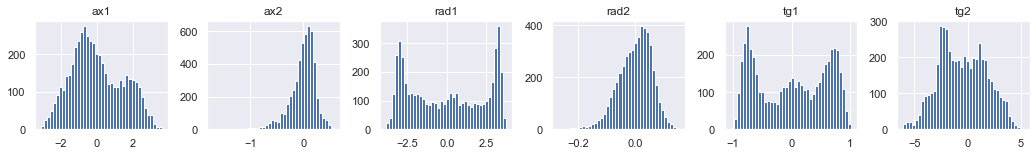

In [6]:
# histograma para cada sinal
m1.time_acc.hist(bins=40, figsize=(24,2), layout=(1,8))
m1.time_acc.describe(percentiles=[.5])

Agora, prosseguimos para o cálculo das características desejadas

In [7]:
def calc_entropy(dataframe):
    entropias = pd.Series(dtype='float64')
    
    for col in dataframe.columns.values[:]:
        # divide cada sinal em 100 faixas e faz a contagem para cada faixa
        out = np.histogram(dataframe[col], bins=100)[0]
        # calcula a entropia de shannon
        entropias[col] = stats.entropy(out)
        
    return entropias

time_stats = pd.DataFrame()
time_stats['rms'] = m1.time_acc.pow(2).sum().pow(1/2)
time_stats['kurtosis'] = m1.time_acc.kurtosis()
time_stats['entropy'] = calc_entropy(m1.time_acc)

time_stats

,rms,kurtosis,entropy
ax1,99.629325,-0.756091,4.393150
ax2,17.532116,3.551579,3.677548
rad1,170.162168,-1.473072,4.452528
rad2,4.058378,0.672311,3.993745
tg1,42.043784,-1.445401,4.468155
tg2,159.985686,-0.730827,4.332292


## Domínio da frequência
Para a estimar a densidade espectral e demais parâmetros no domínio da frequência, outros métodos são sugeridos. Novamente, aqueles implementados são destacados.
 - Coeficientes de autoregressão
 - Features do domínio da frequência (through an FFT transformation):
 - **Vibration levels at characteristic frequencies** of the machine
 - Centro da frequência
 - RMS da frequência
 - Variancia e root-variance da frequência
 - Spectral skewness, kurtosis, entropy
 - Similar features in higher order spectra

## Fundamental
A primeira frequência de interesse é a de rotação do eixo. Ela é obtida a partir do espectro do tacômetro.

In [8]:
def extract_fundamental(fft_df):
    tachometer_fft = fft_df['tacometro'].copy(deep=True)
    candidates = [0, 0, 0]
    
    # separa os 3 maiores picos na fft do tacômetro
    for i in range(3):
        index = tachometer_fft.argmax()
        candidates[i] = fft_df.freq_ax[index]
        
        # retira da próxima iteração os valores adjacentes ao pico separado
        for j in range(-2, 3):
            tachometer_fft[index+j] = 0
    
    # deve retornar pico o de menor frequência, evitando o mascaramento da fundamental pelas harmonicas
    fundamental = min(candidates)
    index = fft_df.index[fft_df['freq_ax'] == fundamental]
    
    return fundamental, index[0]


fundamental, index = extract_fundamental(m1.freq)
print("Fundamental de {:0.2f} Hz, no índice {}".format(fundamental, index))

Fundamental de 55.40 Hz, no índice 277


Pode-se comprovar a correta aquisição da fundamental pelo plot abaixo.

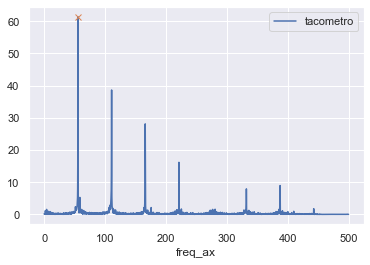

In [9]:
m1.freq.plot(x='freq_ax', y='tacometro')
plt.plot(fundamental, m1.freq.loc[index, 'tacometro'], "x")
plt.show()

## Hamônicas
A extração das hamônicas é feita encontrando o máximo em faixas ao redor da posição esperada para o pico. 

In [10]:
# função implementada na extração de dados

def extract_n_harmonics(fft_df, idx, n_harmonics=3):
    # extrai todos os valores nos n primeiros harmônicos, exceto de freq_ax
    fft_df = fft_df.drop('freq_ax', axis=1)

    harmonic_features = pd.DataFrame(dtype='float64')
    
    for i in range(1, n_harmonics+1):
        # resgata no DataFrame os valores na harmonica i
        harm_values = fft_df.iloc[idx*i-25:idx*i+26].max()
        
        # cria o dataframe com as harmônicas
        harmonic_features["{}th harmonic".format(i)] = harm_values
    
    harmonic_features.loc['freq_ax'] = fundamental * np.arange(1,n_harmonics+1)
    
    
    return harmonic_features

harmonics = extract_n_harmonics(m1.freq_acc, index, 5)

harmonics

,1th harmonic,2th harmonic,3th harmonic,4th harmonic,5th harmonic
ax1,50.308608,3.825595,6.085060,34.564698,10.866869
ax2,7.944732,1.779660,0.923337,2.719953,2.003589
rad1,110.512034,2.737563,1.178578,3.304587,3.977468
rad2,1.839648,0.414001,0.369197,0.437143,0.208031
tg1,26.724106,2.154142,1.675547,1.027618,2.779772
tg2,88.360216,11.807037,6.933858,6.624192,8.013381
freq_ax,55.400000,110.800000,166.200000,221.600000,277.000000


Uma amostra dos picos selecionados pelo algoritmo:

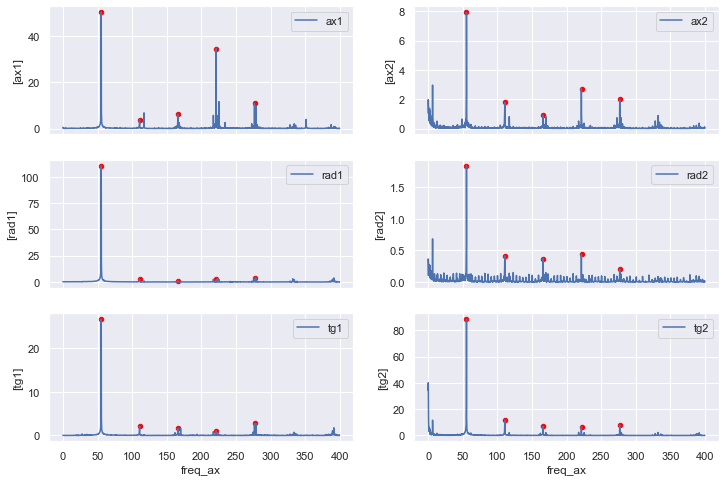

In [11]:
# gera os plots
fig, axes = plt.subplots(3,2,figsize=(12, 8),sharex=True)
for i, col in enumerate(m1.freq_acc.columns.values[:-1]):
    m1.freq[:2000].plot(x='freq_ax', y=[col], ax=axes[i//2,i%2])
    harmonics.T.plot(x='freq_ax', y=[col], ax=axes[i//2,i%2], kind='scatter', color="red")
    
plt.show()

# Experimentos

## Alternativas ao FFT na análise do espectro

Além do FFT puro, pode-se fazer uma estimativa mais geral dos componentes de frequência por outros métodos de análise. Testamos o periodigrama e o periodigrama de Welch.

In [12]:
def generate_periodgram(accelerations, sampling_freq):
    periodgrams = pd.DataFrame(columns = accelerations.columns)

    for col in periodgrams.columns.values:
        f, Pxx = signal.periodogram(accelerations[col], fs=sampling_freq)
        periodgrams[col] = Pxx

    periodgrams['freq_ax'] = f
    
    return periodgrams

def generate_welch_periodgram(accelerations, sampling_freq):
    periodgrams = pd.DataFrame(columns = accelerations.columns)

    for col in periodgrams.columns.values:
        f, Pxx = signal.welch(accelerations[col], fs=sampling_freq)
        periodgrams[col] = Pxx

    periodgrams['freq_ax'] = f
    
    return periodgrams

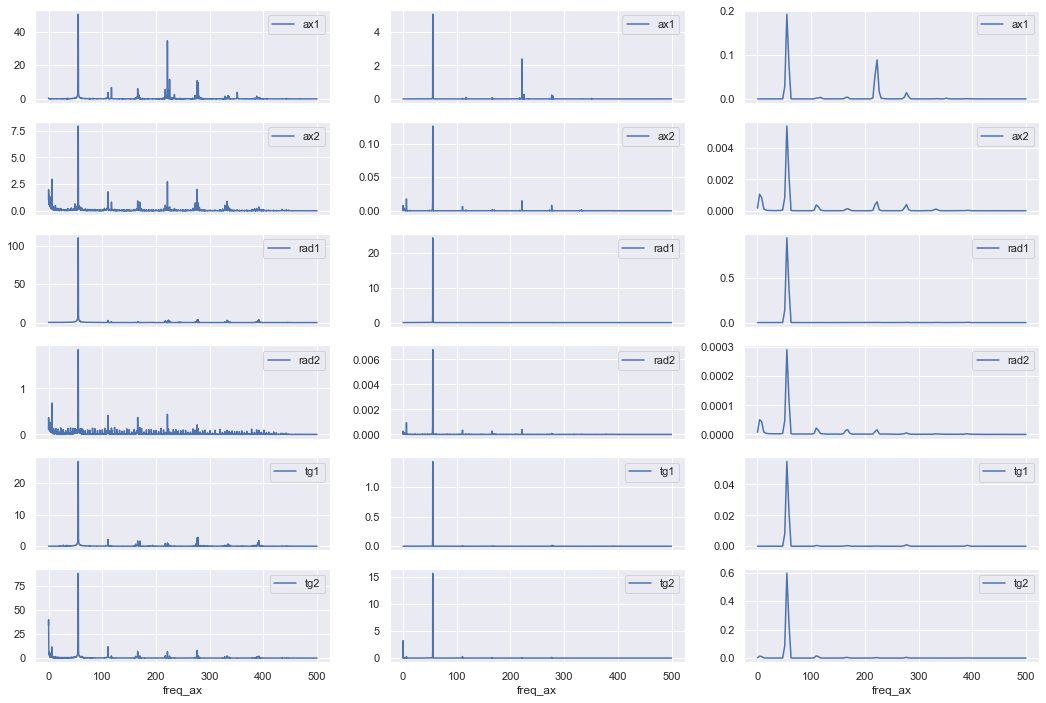

In [13]:
periodgrams = generate_periodgram(m1.time_acc, m1.sampling_freq)
welch = generate_welch_periodgram(m1.time_acc, m1.sampling_freq)

fig, axes = plt.subplots(6,3,figsize=(18, 12),sharex=True)

for i, col in enumerate(m1.freq_acc.columns.values[:-1]):
    m1.freq_acc.plot(x='freq_ax', y=[col], ax=axes[i, 0])
    periodgrams.plot(x='freq_ax', y=[col], ax=axes[i, 1])
    welch.plot(x='freq_ax', y=[col], ax=axes[i, 2])

Nota-se que o valor dos picos é diminuído am termos absolutos, mas se destacam mais em relação ao carpete.

## Análise das velocidades

O sinal de aceleração pode ser integrado para obtenção da velocidade no mesmo eixo. Esta interação, no entanto, acaba exacerbando componentes de baixa frequência. Para evitar a dominação se componentes espúrios de baixa frequência, propõe-se a aplicação de um filtro passa alta depois (ou antes) da integração.

*Nota*: alguns dos sinais de aceleração possuem componentes de 'corrente contínua' (CC), de frequência igual a zero. Elas idicariam que o aquipamento do ensaio possui uma aceleração líquida não nula em algumas das direções. No entanto, o ensaio foi feito sobre báse estática e portanto esse tipo de aceleração não é válida e deve ser ignorada/removida.

Abaixo o filtro butterworth utilizado:

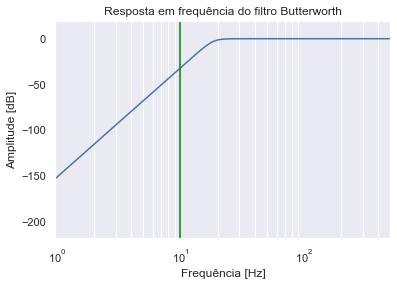

In [14]:
# ilustração do filtro passa alta
from scipy import signal

# define um filtro passa alta arbitrário em 1/3 da fundamental 
b, a = signal.butter(6, fundamental/3, 'highpass', fs=m1.sampling_freq)
w, h = signal.freqz(b, a, fs=m1.sampling_freq)
plt.semilogx(w, 20 * np.log10(abs(h)))

plt.title('Resposta em frequência do filtro Butterworth')
plt.xlabel('Frequência [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(10, color='green') # cutoff frequency
plt.show()

Abaixo integramos os sinais com e sem aplicar o filtro.

In [15]:
from scipy import integrate

# transforna-se o sinal de g para m/s²
m1.time_acc_mmps2 = m1.time_acc*9.80665*1000

# instancia o filtro passa alta
sos = signal.butter(6, 10, 'highpass', fs=m1.sampling_freq, output='sos')

# calcula velocidade pela integral (trapezoidal) dos sinais
velocity_no_filter     = pd.DataFrame()
velocity_filter_before = pd.DataFrame()
filtered_acc           = pd.DataFrame()
velocity_filter_after  = pd.DataFrame()


dt = 1/m1.sampling_freq
for col in m1.time_acc_mmps2.columns:
    velocity_no_filter[col] = integrate.cumtrapz(y=np.array(m1.time_acc_mmps2[col]), dx=dt, initial=0)
    correcao = velocity_no_filter[col].mean()
    velocity_no_filter[col] = velocity_no_filter[col].apply(lambda x: x - correcao)
    
    filtered_acc[col] = signal.sosfilt(sos, m1.time_acc_mmps2[col])
    velocity_filter_before[col] =  integrate.cumtrapz(y=np.array(filtered_acc[col]), dx=dt, initial=0)

    velocity_filter_after[col] = integrate.cumtrapz(y=np.array(m1.time_acc_mmps2[col]), dx=dt, initial=0)
    velocity_filter_after[col] = signal.sosfilt(sos, velocity_filter_after[col])


Nota-se que o sinal não filtrado teve os componentes de baixa frequencia amplificados pela integração.

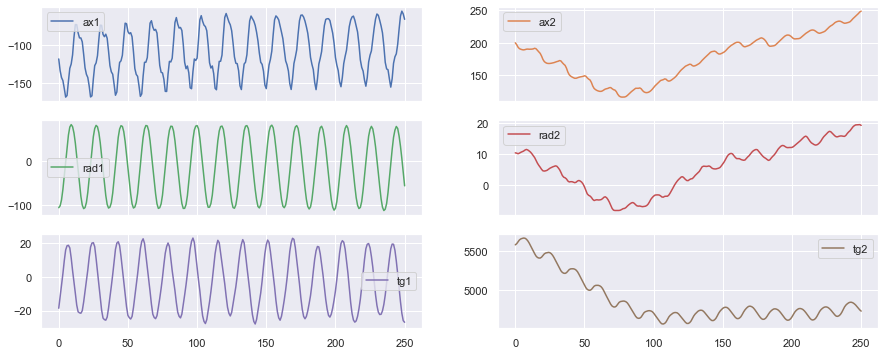

In [16]:
# velocidade NÃO FILTRADA no tempo 
velocity_no_filter.loc[:250].plot(subplots=True, layout=(4,2), figsize=(15,8));

Há diferença entre filtrar os sinais antes ou depois da integração. Filtrar antes garante a remoção dos componentes de CC.

In [17]:
pd.DataFrame({
    'média filtro antes': velocity_filter_after.mean(),
    'média filtro depois': velocity_filter_before.mean()
})

,média filtro antes,média filtro depois
ax1,0.007354,6.432734
ax2,0.004394,0.580414
rad1,0.055761,0.150738
rad2,0.002672,-0.076813
tg1,0.006098,-3.425604
tg2,0.044541,-2.367036


Abaixo, os mesmos sinais na velocidade quando há filtragem antes da interação.

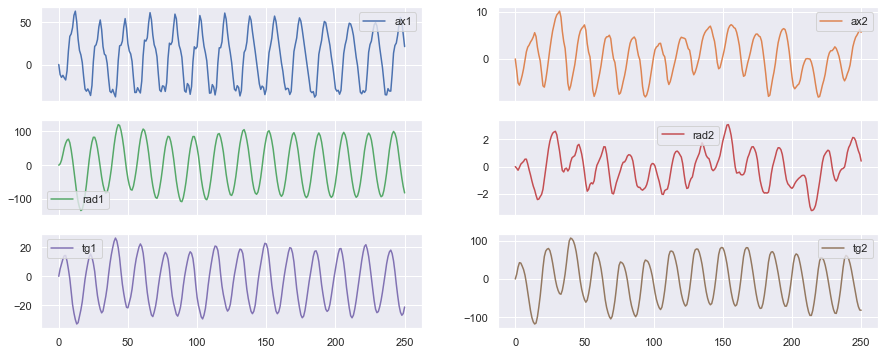

In [18]:
# velocidades FILTRADAS no tempo 
velocity_filter_before.loc[:250].plot(subplots=True, layout=(4,2), figsize=(15,8));

In [19]:
# aplica a transformada no sinal filtrado                                     
velocity_fft = velocity_filter_before.apply(np.fft.rfft, axis=0, norm="ortho")
velocity_fft = velocity_fft.apply(np.abs)
velocity_fft['freq_ax'] = np.linspace(0, m1.sampling_freq/2+1, m1.freq.shape[0])

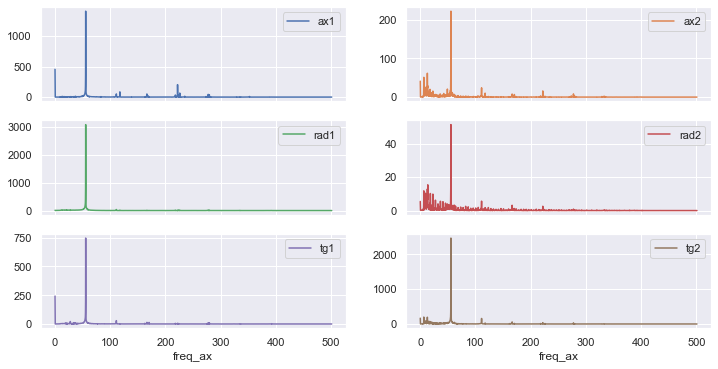

In [20]:
# velocidades na frequência
velocity_fft.loc[:5000].plot(subplots=True, x='freq_ax', layout=(4,2), figsize=(12,8))
plt.show()

In [21]:
# faz tabulação dos valores de velocidade
vel = velocity_fft.iloc[index]
vel.name = 'velocidade'
vel = vel/vel.max()

acc = m1.freq_acc.iloc[index]
acc.name = 'aceleração'
acc = acc/acc.max()

pd.DataFrame([vel,acc])

,ax1,ax2,rad1,rad2,tg1,tg2,freq_ax
velocidade,0.455577,0.071867,1.0,0.016654,0.241832,0.799538,0.018010
aceleração,0.455232,0.071890,1.0,0.016647,0.241821,0.799553,0.501303


Nota-se que os valores de pico na velocidade e na aceleração apresentam a mesma relação de grandeza entre si.

No entanto, analisando os valores RSM há pequenas variações, possivelmente devido ao filtro passa alta.

In [22]:
def rms(x):
    return np.sqrt(x.dot(x)/x.size)

rms_vel = []
for col in velocity_filter_after.columns:
    rms_vel.append( rms(np.array(velocity_filter_after[col])) )
print('RMS velocidades:', rms_vel)

rms_acc = []
for col in accelerations.columns:
    rms_acc.append( rms(np.array(accelerations[col])) )
print('RMS acelerações:', rms_acc)

RMS_values = pd.DataFrame({
    'eixo':  accelerations.columns,
    'aceleração': rms_acc/np.array(rms_acc).max(),
    'velocidade': rms_vel/np.array(rms_vel).max(),
})

print('Valores de RMS:')
sns.catplot(data = RMS_values.melt(id_vars='eixo'), kind='bar', x='eixo', y='value', hue='variable');

RMS velocidades: [30.727295493502343, 6.010698033071823, 66.87594104484484, 1.512646071006762, 16.172995269698266, 54.320148531308284]


NameError: name 'accelerations' is not defined

## Extração ingênua dos picos na frequência
Note que há uma série de valores elevados em torno de um mesmo pico, confundindo a análise.

In [ ]:
STUDY_FFT = signals_fft[['freq_ax','ac1ax']]

col_name = STUDY_FFT.columns[1]
ordered_study_fft = STUDY_FFT.sort_values(by=col_name, ascending=False) # ordenando o sinal
ordered_study_fft['n_harmonic'] = ordered_study_fft['freq_ax']/fundamental

pd.options.display.float_format = '{:,.3f}'.format


ax = signals_fft.iloc[:1000,:].plot(x='freq_ax', y=col_name)
ordered_study_fft.iloc[:4,:].plot(x='freq_ax', y=col_name, kind='scatter', color='red', ax=ax)
plt.show()

# mostra tabela
ordered_study_fft.iloc[:4,:]